In [12]:
import os
import mne
import pyxdf
import numpy as np
import matplotlib.pyplot as plt
from src.UnicornData import UnicornData

In [13]:
data_path = '../../data/cit/'
data_file = 'cit_wiko.xdf'
os.listdir(data_path)

['cit_luka.csv',
 'cit_wiko.csv',
 'cit_luka.xdf',
 'cit_wiko.xdf',
 'cit_nani.xdf',
 'cit_nani.csv']

In [14]:
CONST_OFFSET = 0.073  # Delay measured with photodiode that day

In [15]:
data =  UnicornData(f'{data_path}/{data_file}', delay=CONST_OFFSET)
raw = data.filter().raw

Markers 240
Data 124796
Creating RawArray with float64 data, n_channels=8, n_times=124796
    Range : 0 ... 124795 =      0.000 ...   499.180 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rip

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [16]:
events = data.events
# events
irrelevant_events = [1, 3, 4, 5]
probe_event, target_event = [6], [2]
merged_events = mne.merge_events(events, irrelevant_events, 3)
merged_events = mne.merge_events(merged_events, probe_event, 1)
merged_events = mne.merge_events(merged_events, target_event, 2)
event_dict = dict(probe=1, target=2, irrelevant=3)
tmin, tmax = -0.2, 1.3
epochs = mne.Epochs(raw, merged_events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None))

Not setting metadata
239 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 239 events and 376 original time points ...
0 bad epochs dropped


In [17]:
# Assume epochs is your MNE Epochs object
probe_epochs = epochs['probe']
target_epochs = epochs['target']
irrelevant_epochs = epochs['irrelevant']

n = len(probe_epochs)

n_boot = 1000
p300_time_window = (0.300, 0.800)
neg_time_window = (0.300, .900)
picks = "Pz"

boot_diffs = []
boot_epochs = []

for _ in range(n_boot):
    # Resample with replacement
    probe_resampled = probe_epochs[np.random.choice(n, n, replace=True)]
    irr_resampled = irrelevant_epochs[np.random.choice(n, n, replace=True)]
    target_resampled = target_epochs[np.random.choice(len(target_epochs), len(target_epochs), replace=True)]

    # Average to ERP
    probe_avg = probe_resampled.average()
    irr_avg = irr_resampled.average()
    target_avg = target_resampled.average()

    # Extract data
    probe_data = probe_avg.copy().pick(picks).data
    irr_data = irr_avg.copy().pick(picks).data
    target_data = target_avg.copy().pick(picks).data

    # Time mask for P300 window
    times = probe_avg.times
    mask = (times >= p300_time_window[0]) & (times <= p300_time_window[1])


    # Compute P300 latency using 100-ms moving window
    def peak_to_peak(data):
        window_size = int(0.1 * probe_avg.info['sfreq'])  # 100 ms window
        max_avg_amp = -np.inf
        p300_latency = None
        # Find P300 latency
        for start in range(np.where(mask)[0][0], np.where(mask)[0][-1] - window_size + 1):
            window_avg = np.mean(data[0, start:start + window_size])
            if window_avg > max_avg_amp:
                max_avg_amp = window_avg
                p300_latency = times[start + window_size // 2]
        # Find following negative peak using 100-ms moving window
        neg_mask = (times >= p300_latency) & (times <= neg_time_window[1])
        min_avg_amp = np.inf
        for start in range(np.where(neg_mask)[0][0], np.where(neg_mask)[0][-1] - window_size + 1):
            window_avg = np.mean(data[0, start:start + window_size])
            if window_avg < min_avg_amp:
                min_avg_amp = window_avg
        p2p_amp = max_avg_amp - min_avg_amp
        return p2p_amp


    def max_min_diff(data):
        max_amp = np.max(data[0, mask])
        min_amp = np.min(data[0, mask])
        return max_amp - min_amp


    # probe_metric = peak_to_peak(probe_data)
    # irr_metric = peak_to_peak(irr_data)

    probe_metric = max_min_diff(probe_data)
    irr_metric = max_min_diff(irr_data)
    target_metric = max_min_diff(target_data)

    boot_diffs.append(probe_metric - irr_metric)
    boot_epochs.append((probe_avg, irr_avg, target_avg))

boot_diffs = np.array(boot_diffs)

# Decision criterion
perc_positive = np.mean(boot_diffs > 0) * 100
knowledgeable = perc_positive >= 90
print(f"Percent > 0: {perc_positive:.1f}%")
print("Guilty:", knowledgeable)

Percent > 0: 87.2%
Guilty: False


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


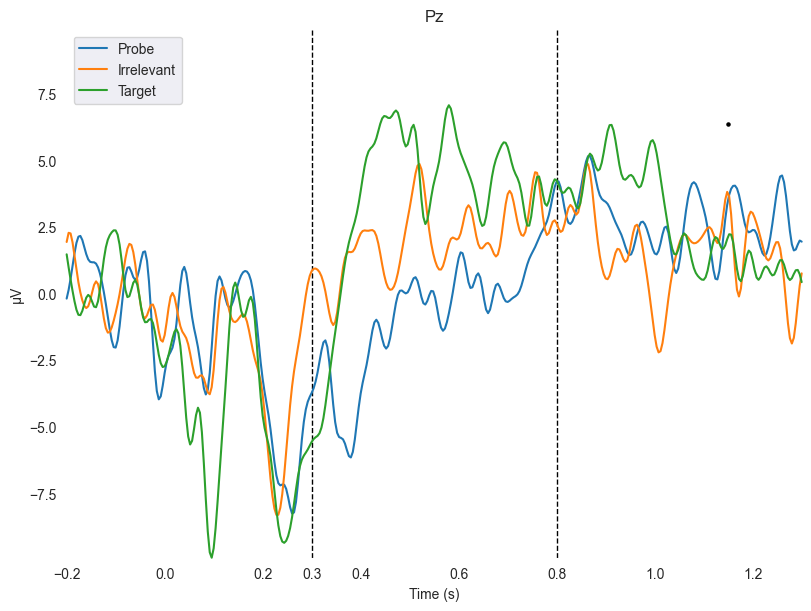

In [18]:
all_probes = [be[0] for be in boot_epochs]
all_irrs = [be[1] for be in boot_epochs]
all_targets = [be[2] for be in boot_epochs]
all_probes = mne.grand_average(all_probes)
all_irrs = mne.grand_average(all_irrs)
all_targets = mne.grand_average(all_targets)

mne.viz.plot_compare_evokeds(
    {"Probe": all_probes, "Irrelevant": all_irrs, "Target": all_targets},
    picks="Pz",
    vlines=list(p300_time_window),
    show=True
)

plt.show()

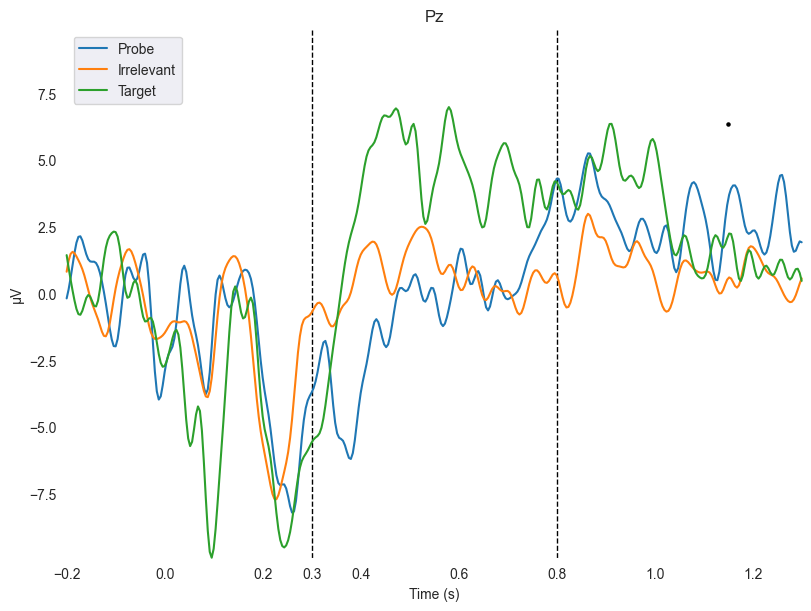

In [19]:
# Compute evokeds
probe_evoked = probe_epochs.average()
irrelevant_evoked = irrelevant_epochs.average()

# Plot together at Pz
mne.viz.plot_compare_evokeds(
    {"Probe": probe_evoked, "Irrelevant": irrelevant_evoked, "Target": target_epochs.average()},
    picks="Pz",
    vlines=list(p300_time_window),
    show=True
)

plt.show()